11 0.635602874137
9 -0.676644045789
610 386
724 464
-1.71775322379


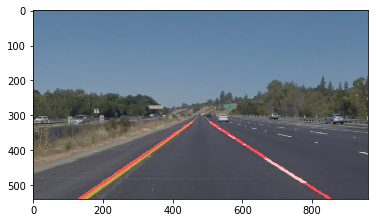

In [109]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import cv2
import math
import os

%matplotlib inline


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)   

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=6):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    i=0
    l =0
    r=0
    rIntercept = 0
    lIntercept=0
    lSlope = 1
    rSlope =1
    lSlopeSum = 0
    rSlopeSum =0
    yRFinal =1000
    xRFinal = 0
    yRStart=0
    xRStart=0
    yLFinal =1000
    xLFinal = 0
    yLStart=0
    xLStart=0
    #print (lines.size)
    for line in lines:
        for x1,y1,x2,y2 in line:
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            if i<3:
                slope = ((y2-y1)/(x2-x1))
                #print (slope)
                if slope > 0 and x2>480 and x1>480: 
                    r = r+1
                    rSlopeSum=rSlopeSum+slope
                    if y2<yRFinal :
                        yRFinal= y2
                        xRFinal=x2
                    if y1>yRStart:
                        yRStart=y1
                        xRStart=x1
                if slope < 0 and x2<480 and x1<480:
                    l = l+1
                    lSlopeSum=lSlopeSum+slope
                    if y2<yLFinal  :
                        yLFinal= y2
                        xLFinal=x2
                    if y1>yLStart:                        
                        yLStart=y1
                        xLStart=x1
                    
    rSlope = rSlopeSum/r
    lSlope = lSlopeSum/l
    #print (r, rSlope)
    #print (l,lSlope)
    
    #print (xLFinal, yLFinal)
    #print (xLStart,yLStart)
    #print (xRFinal, yRFinal)
    #print (xRStart,yRStart)
    
    #y = ax+b
    #yLFinal = lSlope(xLFinal) + intercept
    lIntercept = yLFinal - (lSlope*xLFinal)
    rIntercept = yRFinal - (rSlope*xRFinal)
    #print (rIntercept)
    #print(lIntercept)
    #y=ax+b y-b=ax x= y-b/a
    xRStartDraw = int((540 - rIntercept)/rSlope)
    xREndDraw = int((320 - rIntercept)/rSlope)
    #print (xRStartDraw,540)
    #print(xREndDraw,320)
    
    xLStartDraw = int((540 - lIntercept)/lSlope)
    xLEndDraw = int((320 - lIntercept)/lSlope)
    #print (xLStartDraw,540)
    #print(xLEndDraw,320)
    #finalSlope = ((YFinal - YStart) - (XFinal - XStart))
    #print (finalSlope)
    #yRFinal = 540
    
    cv2.line(img, (xRStartDraw, 540), (xREndDraw, 320), color, thickness)
    cv2.line(img, (xLStartDraw, 540), (xLEndDraw, 320), color, thickness)
            
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def process_img(img):

    #img = mpimg.imread('./test_images/solidWhiteRight.jpg')
    #print('This image is: ',type(img), 'with dimensions:', img.shape)

    # Note: always make a copy rather than simply using "="
    color_select = np.copy(img)
    #plt.imshow(color_select)
    #plt.show()
    grayimage = grayscale(color_select)
    #plt.imshow(grayimage, cmap='gray')
    #plt.show()
    #grayimage = color_select
    guassianBlurImg = gaussian_blur(grayimage,7)
    #plt.imshow(guassianBlurImg, cmap='gray')
    #plt.show()

    cannyImg = cv2.Canny(guassianBlurImg,150,170)
    #plt.imshow(cannyImg, cmap='Greys_r')
    #plt.show()

    imshape = img.shape
    vertices = np.array([[(70,imshape[0]),(430, 330), (550, 320), (860,540)]], dtype=np.int32)
    maskedImg = region_of_interest(cannyImg,vertices)
    #plt.imshow(maskedImg)
    #plt.show()

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 15 # distance resolution in pixels of the Hough grid
    theta= np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 125     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10 #minimum number of pixels making up a line
    max_line_gap = 30    # maximum gap in pixels between connectable line segments
    line_image = np.copy(img)*0 # creating a blank to draw lines on

    lined_img = hough_lines(maskedImg, rho, theta, threshold,min_line_length, max_line_gap)

    weightedImg = weighted_img(lined_img,img)
    #plt.imshow(weightedImg)
    #plt.show()
    #img_name = "Converted_" + name
    #cv2.imwrite(img_name, weightedImg)
    return weightedImg

list = os.listdir("test_images/")
#print (list[0])

file_path = "./test_images/" + list[4]
#processedImg = process_img(mpimg.imread(file_path))

white_output = 'White5.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_img) #NOTE: this function expects color images!!
#white_clip.preview()
%time white_clip.write_videofile(white_output, audio=False)

yellow_output = 'Yellow5.mp4'
clip2 = VideoFileClip("solidYellowLeft.mp4")
yellow_clip = clip2.fl_image(process_img) #NOTE: this function expects color images!!
#white_clip.preview()
%time yellow_clip.write_videofile(yellow_output, audio=False)


